# Кластеризация предобработанных данных

## Цель проекта 
На обезличенных данных выделить сегменты клиентов по их покупательскому поведению. Внутри одного сегмента клиенты должны быть схожи между собой. Клиенты, попавшие в разные сегменты, должны иметь существенные отличия в своих покупках в баре.
Сегментация делается для дальнейшего маркетингового анализа, выделения привлекательных (целевых) сегментов клиентов, разработки адекватного продуктового предложения и позиционирования. 

## Задача проекта
Методом кластеризации разделить клиентов на группы и описать выявленные сценарии покупательского поведения.

## Данные 
Покупки клиентов бара в течение 1 месяца (Дата-фрейм получен в ноутбуке "1Предобработка и разведочный анализ").

## Этапы работы 

1. Оцениваем число кластеров с помощью Метода локтя и Алгоритма DBSCAN. В качестве метрики выбираем Коэф.силуэта, т.к. мы не располагаем размеченными данными. Результат: предварительно рассматриваем версию разбиения на 2-4 кластера.

2. Визуализируем кластеры. Для этого стандартизированные наблюдения размещаем на двумерной плоскости с помощью методов снижения размерности PCA и T-SNE

3. Находим центры кластеризации с помощью KMeans.

    3.1. Для нестандартизированных данных получаем 3 кластера, кластеры отличаются по кол-ву посещений и ARPU. Данное разбиение отражает 3 разных сценария посещения бара.

    3.2. Для стандартизированных данных:  неудовлетворительный максимальный коэф.силуэта (0.407) и размытая интерпретация данных.

    3.3. Для нормализованных данных: несмотря на неубедительные коэф.силуэта, кластеризация происходит с жёсткой разбивкой по полу (м/ж), что представляет интерес. Получаем 4 кластера, отличающихся по полу (м/ж) и дню недели посещения (сб - для мужчин, пт - для девушек).

4. Дополнительные расчеты: 

    4.1. Агломеративная кластеризация
    
    4.2. Иерархическая кластеризация, 
    
    4.3. Проверка на данных, которые не содержат аномалий, выявленных алгоритмом DBSCAN.

    Подтверждается разбивка на 2-4 кластера.


## Выводы:

### 3 кластера отражают 3 разных сценария посещения бара (получены методом K-Means) в зависимости от количества посещений в месяц, состава компаниии, что отражается на доходности клиентов (ARPU)

### 4 кластера образовались при жёстком разбиении по полу и дню недели посещения (сб - для мужчин, пт - для девушек). Получены методом K-Means для нормализованных данных.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from scipy.cluster.hierarchy import linkage, dendrogram
from itertools import cycle, islice

In [2]:
warnings.simplefilter('ignore')

In [3]:
def load(file, num):
    "Функция для получения трёх вариантов данных: исходных X, стандартизированных X1 и нормализованных X2"
    
    X = pd.read_excel(file)

    scaler1 = StandardScaler()
    X1 = scaler1.fit_transform(X)

    scaler2 = MinMaxScaler()
    X2 = scaler2.fit_transform(X)
    
    if num == 0:
        return X
    elif num == 1:
        return X1
    elif num == 2:
        return X2

In [4]:
# Наименование файла передаём в переменную file_name1:
file_name1 = 'Data_Sept2019.xlsx'

In [5]:
X=load(file_name1, 0)
X.shape

(15577, 35)

In [6]:
X1=load(file_name1, 1)
X2=load(file_name1, 2)

## 1. Оцениваем число кластеров с помощью Метода локтя и Алгоритма DBSCAN

In [7]:
def elbow(X):
    "Функция для визуализации результата кластеризации по методу локтя"
    
    sse = {}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
        X["clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
    list1 = sse.keys()
    list2 = sse.values()

    plt.figure()
    plt.plot(list1, list2)
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    return plt.show()

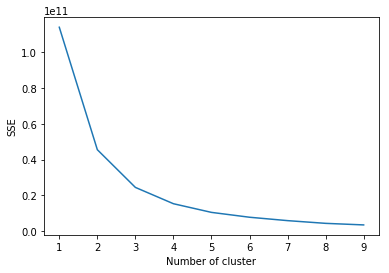

In [8]:
elbow(X)

1. МЕТОД ЛОКТЯ показывает, что после 4-х кластеров дальнейшая сегментация не даёт существенного уменьшения SSE (суммы квадратов ошибок до центра кластера).


2. Для DBSCAN создаём список с вариантами параметра eps и перебираем этот параметр в цикле.
    Смотрим, в каком случае коэффициент силуэта максимальный с приемлемым количеством выбросов.

    Используем X2 = MinMaxScaler().fit_transform(X)

    При eps=0.7 алгоритм DBSCAN выдаёт 2 примерно одинаковых кластера (коэф.силуэта = 0.589, выбросов 100 наблюдений из 15577).

    В качестве метрики выбираем Коэф.силуэта, т.к. мы не располагаем размеченными данными

### Итак, предварительно рассматриваем версию разбиения на 2-4 кластера. 

In [9]:
param = []
for x in range(1,10):
    param.append(x/10)
    param.append(round(x/10+0.05,2))
print(param)

[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


In [10]:
def dbscan_sil(low, high):
    "Функция для расчета коэф.силуэта при использовании DBSCAN. Аргументы: номера элементов из сгененирированного списка param"

    for j in param[low:high]:
    
        dbscan = DBSCAN(eps=j, min_samples=100)
        dbscan.fit(X2)
        y_pred = dbscan.labels_.astype(np.int)
        s = silhouette_score(X=X2, labels=y_pred, metric='euclidean')
        print('eps ', j, s)
    
        counts = np.unique(y_pred, return_counts=True)
        for count in counts: 
            print(count, end='\n')
        
        df10 = pd.read_excel(file_name1)
        
        feature_names = df10.columns.tolist()
        for element in feature_names:
            if element == 'Кластер DBSCAN':
                df10 = df10.drop(element, axis='columns')
              
        df10['Кластер DBSCAN'] = df10.apply(lambda x: 0) 

        for number, i in enumerate(y_pred):
            df10.loc[[number],'Кластер DBSCAN']=i
            
        with pd.ExcelWriter(str(int(j*100))+'.xlsx') as writer:  # doctest: +SKIP
            df10.to_excel(writer, sheet_name='data', index=False)

In [11]:
dbscan_sil(11,13)

eps  0.65 0.5889171856978155
[-1  0  1]
[ 134 7935 7508]
eps  0.7 0.5891135536681112
[-1  0  1]
[ 100 7956 7521]


## 2. Визуализируем кластеры

Для этого стандартизированные наблюдения размещаем на двумерной плоскости с помощью методов снижения размерности PCA, T-SNE

In [12]:
def visual_comp(file):
    "Функция для снижения размерности и визулизации 2,3,4 кластеров. Снижение размерности методами PCA, TSNE"
    
    load(file, 1)
    dec = PCA(n_components = 2).fit_transform(X1)
    X_embedded = TSNE(n_components=2).fit_transform(X1)

    # создаём массив пар – датасета и соответствующих для него параметров алгоритма
    datasets_params_list = [
        (dec, {'n_clusters': 2}),
        (dec, {'n_clusters': 3}),
        (dec, {'n_clusters': 4}),
        (X_embedded, {'n_clusters': 2}),
        (X_embedded, {'n_clusters': 3}),
        (X_embedded, {'n_clusters': 4})]

    for i, (X, k_means_params) in enumerate(datasets_params_list, start=1):
        X = StandardScaler().fit_transform(X)
        k_means = KMeans(n_clusters=k_means_params['n_clusters'])
    
        k_means.fit(X)
        y_pred = k_means.labels_.astype(np.int)
    
        # Step size of the mesh. Decrease to increase the quality of the VQ.
        h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

        # Plot the decision boundary. For that, we will assign a color to each
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Obtain labels for each point in mesh. Use last trained model.
        Z = k_means.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.subplot(f'23{i}')
        #plt.clf()
        plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

        plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)    

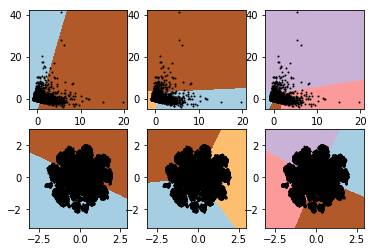

In [13]:
visual_comp(file_name1)

1. Метод главных компонент PCA в сочетании с K-Means выдает разные по объему кластеры
2. Метод T-SNE в сочетании с алгоритмом K-Means разбивает наблюдения примерно на равные по объему кластеры

## 3. Для получения центров кластеризации используем K-Means

Определим количество кластеров перебором значений от 2 до 8. Вычисляем коэф.силуэта.

Определяем центры получившихся кластеров.

In [14]:
def silhouette(file, num, low, high):
    "Подсчет коэф.силуэта при использовании KMeans. Аргументы low, high: границы числа кластеров"
    
    X = load(file, num)
    dict={}
    for i in range(low, high):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        kmeans_pred = kmeans.labels_
        dict[i] = round((silhouette_score(X=X, labels=kmeans_pred, metric='euclidean')), 3)
        
    list10=[]
    list20=[]
    
    for j in dict.keys():
        list10.append(j)
            
    for j in dict.values():
        list20.append(j)        
            
    result = pd.DataFrame(list20)
    result.index = list10
    result = result.reset_index()
    result.columns = ['К-во кластеров', 'Коэф.силуэта']
    
    display(result)

In [16]:
def k_center(file, num):
    "Функция для кластеризации и нахождения центров кластеров методом KMeans"
    
    for j in range(2,5):
        
        df10 = pd.read_excel(file)
                
        if num == 0:
            X = df10
            name = 'non_standard'
            
        elif num == 1:
            scaler1 = StandardScaler()
            X = scaler1.fit_transform(df10)
            name = 'standard'
            
        elif num == 2:
            scaler2 = MinMaxScaler()
            X = scaler2.fit_transform(df10)
            name = 'MinMax'
            
        name1=file.split('.')[0]
    
        kmeans = KMeans(n_clusters=j, random_state=42)
        # Для обучения модели K-means необходимо вызвать метод fit, передав входным параметром признаки объектов датасета:
        kmeans.fit(X)
        
        # Обучив, мы можем получить центроиды кластеров:
        if num == 0:
            a = kmeans.cluster_centers_
        elif num == 1:
            a1 = kmeans.cluster_centers_
            a = scaler1.inverse_transform(a1)    
        elif num == 2:
            a1 = kmeans.cluster_centers_
            a = scaler2.inverse_transform(a1)

        # Определяем, в какой кластер попал каждый из объектов:
        b = kmeans.labels_

        # Для подсчёта элементов в списке можно воспользоваться функцией numpy.unique с параметром return_counts=True:

        counts = np.unique(b, return_counts=True)
        for count in counts:
            print(count, end=' ')
    
        feature_names = df10.columns.tolist()
        for element in feature_names:
            if element == 'Кластер K-means':
                df10 = df10.drop(element, axis='columns')

        feature_names = df10.columns
        featureImportance = pd.DataFrame(np.round(a, 2)) 
        featureImportance.columns = feature_names

        df10['Кластер K-means'] = df10.apply(lambda x: 0) 

        for number, i in enumerate(b):
            df10.loc[[number],'Кластер K-means']=i

        for number, i in enumerate(count):
            featureImportance.loc[[number],'К-во']=i
    
        list = []
        list.append(featureImportance.columns[-1])
        for i in feature_names:
            list.append(i)
    
        featureImportance = featureImportance[list].T
        
        list2 = featureImportance.columns.tolist()
        for k in range(len(list2)):
            featureImportance['Per 1 visit for cluster'+str(k)]=featureImportance[k].apply(lambda x: 
                             round(x/(featureImportance.loc['Посещений', k]), 2))   
        
        featureImportance1 = featureImportance.reset_index()
                
        #with pd.ExcelWriter(name1+name+'Clusters'+str(int(j))+'.xlsx') as writer:  # doctest: +SKIP
        #    df10.to_excel(writer, sheet_name='data', index=False)
        #    featureImportance1.to_excel(writer, sheet_name='short')
        display(featureImportance1)
        
        f, axes = plt.subplots(1, 2)
        sns.boxplot(x = df10['Кластер K-means'], y = df10['ARPU'], data = df10, hue = 'Пол', ax = axes[0])
        sns.boxplot(x = df10['Кластер K-means'], y = df10['Сеты'], data = df10, hue = 'Пол', ax = axes[1])
        
        data0 = featureImportance.drop(index=['К-во', 'Пол', 'ARPU'], axis=0)
        list3 = data0.columns.tolist()
        k = int(0.5*len(list3))
        list3 = list3[-k:]
        data0 = data0.reset_index()
                
        cat_par = [i for i in data0['index'].values.tolist()]
        g = [i for i in range(len(list3))]
        for k in range(len(list3)):
            g[k] = [i for i in data0['Per 1 visit for cluster'+str(k)]] 
        width = 0.4
        x = np.arange(len(cat_par))
        fig, ax = plt.subplots(figsize=(18,18))
        
        for k in range(len(list3)):
            if len(list3)==2:
                rects1 = ax.barh(x - width/len(list3), g[k], width, label=('g'+str(k)))
                rects2 = ax.barh(x + width/len(list3), g[k+1], width, label=('g'+str(k+1)))
                break
        
            if len(list3)==3:
                rects1 = ax.barh(x - width/len(list3), g[k], width*0.7, label=('g'+str(k)))
                rects2 = ax.barh(x, g[k+1], width*0.7, label=('g'+str(k+1)))
                rects3 = ax.barh(x + width/len(list3), g[k+2], width*0.5, label=('g'+str(k+2)))
                break
                
            if len(list3)==4:
                rects1 = ax.barh(x - width/len(list3), g[k], width, label=('g'+str(k)))
                rects2 = ax.barh(x + width/len(list3), g[k+1], width, label=('g'+str(k+1)))
                rects3 = ax.barh(x - width/len(list3), g[k+2], width*0.5, label=('g'+str(k+2)))
                rects4 = ax.barh(x + width/len(list3), g[k+3], width*0.5, label=('g'+str(k+3)))
                break
                
        ax.set_title('Показатели на 1 посещение в разных кластерах')
        ax.set_yticks(x)
        ax.set_yticklabels(cat_par)
        ax.legend()
        plt.show()
              
        print('\n')

###  3.1. Для нестандартизированных данных X:
* При 2-х кластерах коэф.силуэта максимальный (0.715)
* При 3-х 0.648
* При 4-х 0.611

In [17]:
silhouette(file_name1, 0, 2, 9)

,К-во кластеров,Коэф.силуэта
0,2,0.715
1,3,0.648
2,4,0.611
3,5,0.583
4,6,0.569
5,7,0.564
6,8,0.555


[0 1] [13476  2101] 

,index,0,1,Per 1 visit for cluster0,Per 1 visit for cluster1
0,К-во,13476.00,2101.00,10780.80,817.51
1,Пол,0.50,0.58,0.40,0.23
2,ARPU,1895.43,8026.80,1516.34,3123.27
3,Посещений,1.25,2.57,1.00,1.00
4,Коктейли для друзей,0.41,2.37,0.33,0.92
5,Акции,0.40,1.99,0.32,0.77
6,Лонги,1.01,3.71,0.81,1.44
7,Пиво для друзей,0.46,1.77,0.37,0.69
8,Пиво до 1л,1.83,5.09,1.46,1.98
9,Сеты,1.19,6.29,0.95,2.45


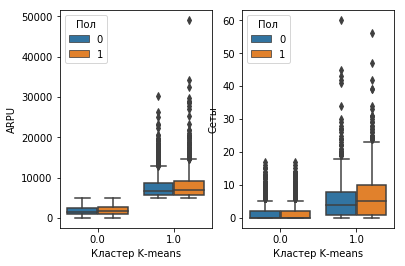

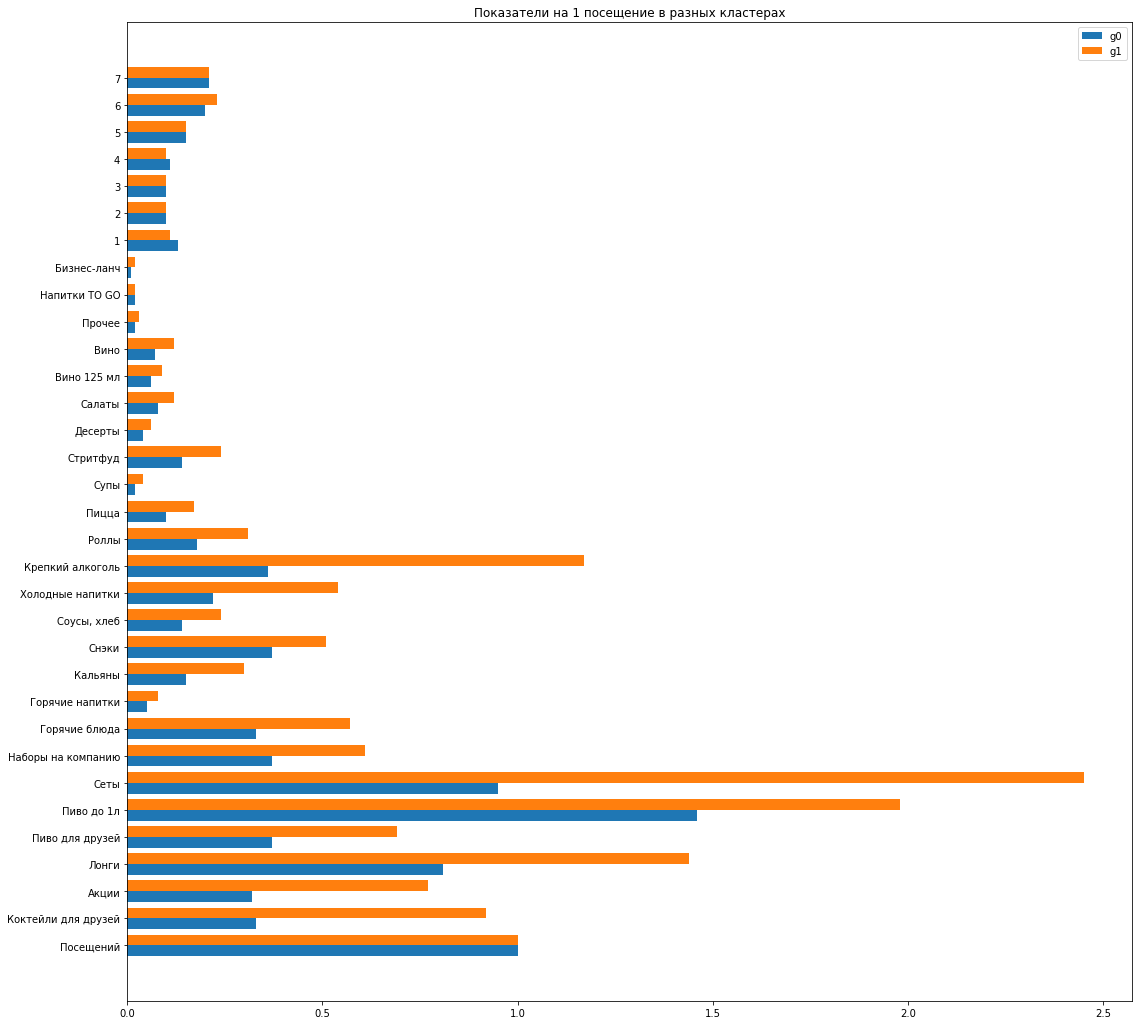



[0 1 2] [11416  3595   566] 

,index,0,1,2,Per 1 visit for cluster0,Per 1 visit for cluster1,Per 1 visit for cluster2
0,К-во,11416.00,3595.00,566.00,9674.58,1912.23,155.07
1,Пол,0.50,0.55,0.62,0.42,0.29,0.17
2,ARPU,1513.03,5033.58,12442.15,1282.23,2677.44,3408.81
3,Посещений,1.18,1.88,3.65,1.00,1.00,1.00
4,Коктейли для друзей,0.29,1.43,3.60,0.25,0.76,0.99
5,Акции,0.29,1.25,3.14,0.25,0.66,0.86
6,Лонги,0.83,2.49,5.22,0.70,1.32,1.43
7,Пиво для друзей,0.37,1.11,2.98,0.31,0.59,0.82
8,Пиво до 1л,1.62,3.42,7.97,1.37,1.82,2.18
9,Сеты,0.89,3.77,9.70,0.75,2.01,2.66


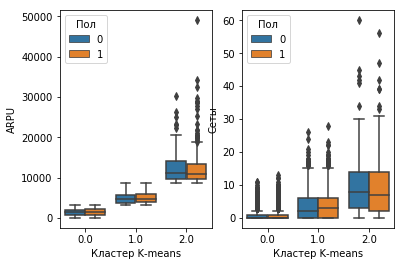

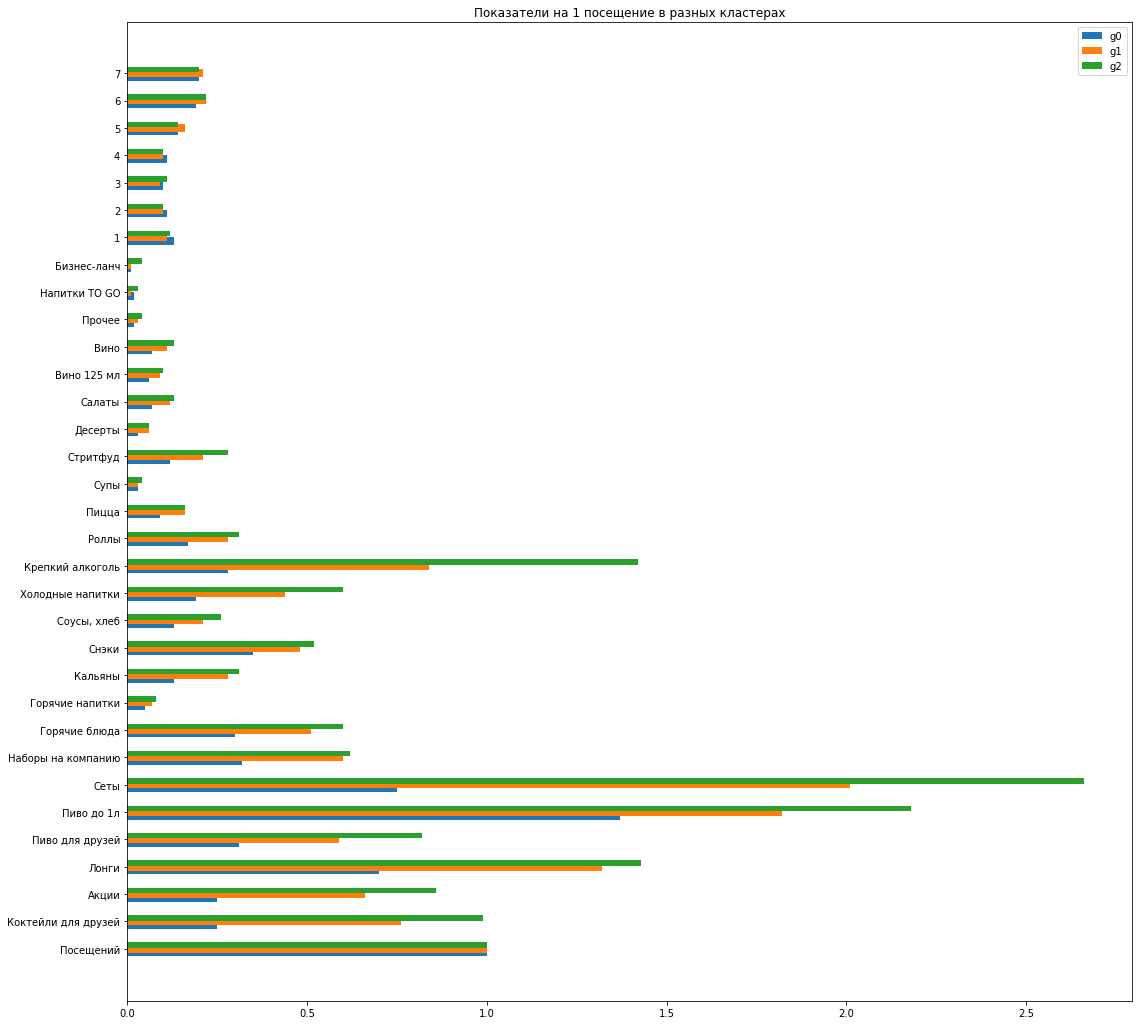



[0 1 2 3] [4320 1325 9696  236] 

,index,0,1,2,3,Per 1 visit for cluster0,Per 1 visit for cluster1,Per 1 visit for cluster2,Per 1 visit for cluster3
0,К-во,4320.00,1325.00,9696.00,236.00,2683.23,538.62,8580.53,51.30
1,Пол,0.53,0.58,0.49,0.60,0.33,0.24,0.43,0.13
2,ARPU,3723.47,7737.96,1272.45,15810.67,2312.71,3145.51,1126.06,3437.10
3,Посещений,1.61,2.46,1.13,4.60,1.00,1.00,1.00,1.00
4,Коктейли для друзей,0.96,2.29,0.22,4.70,0.60,0.93,0.19,1.02
5,Акции,0.93,1.95,0.22,3.87,0.58,0.79,0.19,0.84
6,Лонги,1.86,3.59,0.73,6.55,1.16,1.46,0.65,1.42
7,Пиво для друзей,0.88,1.70,0.31,3.70,0.55,0.69,0.27,0.80
8,Пиво до 1л,2.75,4.78,1.50,10.59,1.71,1.94,1.33,2.30
9,Сеты,2.67,6.08,0.69,12.32,1.66,2.47,0.61,2.68


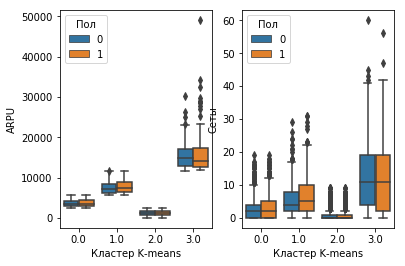

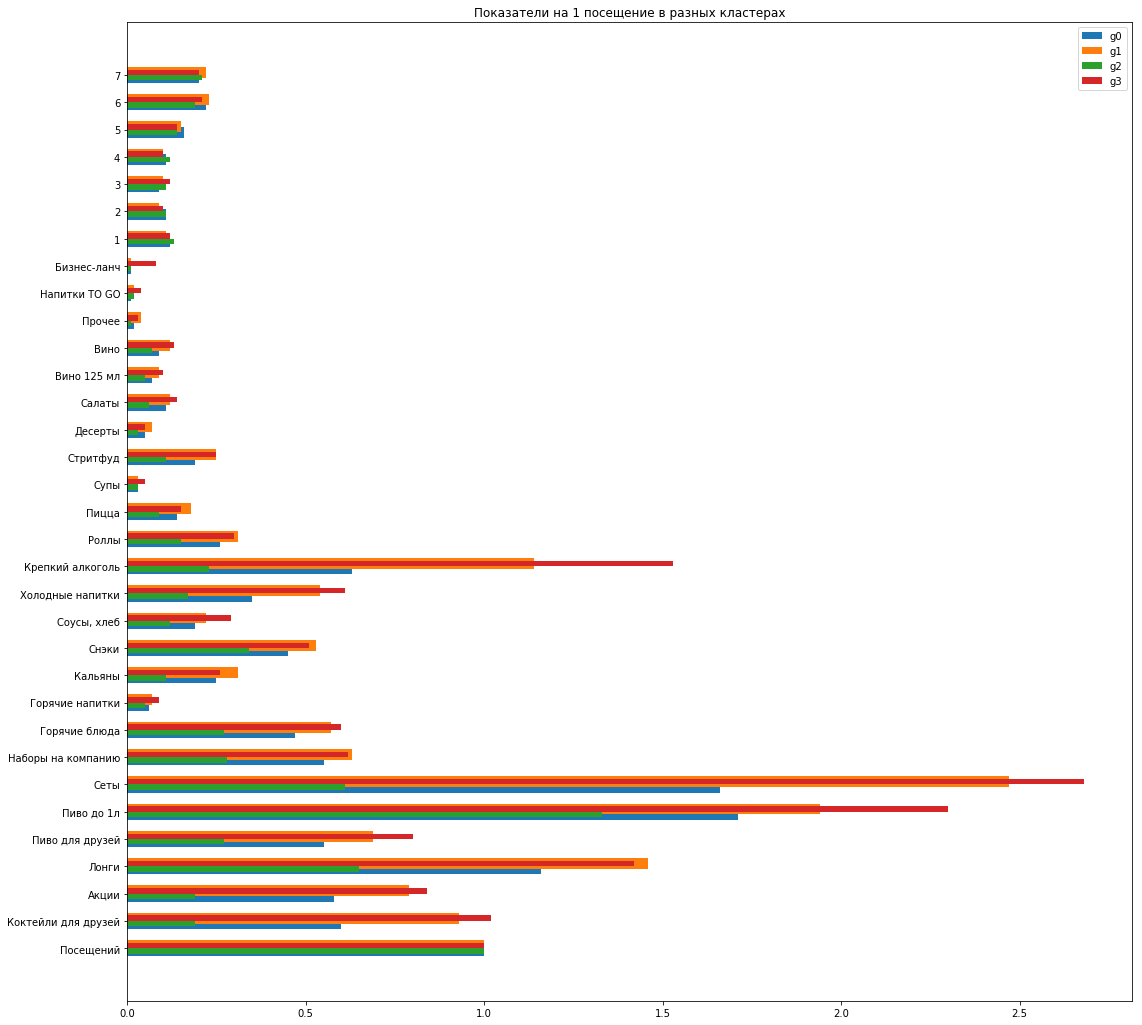

In [18]:
k_center(file_name1, 0)

### Итак, методом K-Means для нестандартизированных данных X получаем 2, 3, 4 кластера. Кластеры отличаются по кол-ву посещений и ARPU

#### При разбиении на 2 кластера средние цифры выглядят так:

* 1-й кластер (13476 клиентов): Посещений 1,25 раз в месяц и ARPU 1895 руб. Пол: поровну мужчин и девушек.

* 2-й кластер (2101 клиент): Посещений 2,57 раз в месяц и ARPU 8027 руб. Пол: чаще мужчины, чем девушки. 
Во 2-м кластере посещений на 1 человека в 2 раза больше, при этом непропорционально больше заказывается "Коктейлей для друзей"
(куда входят 3 порции), Лонгов (=коктейлей), Пива для друзей (3 порции в наборе), Крепкий алкоголь и холодные напитки 
(к нему же), Сетов. 
Это более компанейский вариант посещения.


#### При разбиении на 3 кластера средние цифры выглядят так:

Основная масса клиентов попала в кластер 1. Сосредоточим своё внимание на более высокодоходных клиентах из кластеров 2 и 3.
Средние цифры выглядят так:

* 1-й кластер (11416 клиентов): Посещений 1,18 раз в месяц и ARPU 1513 руб. Пол: поровну мужчин и девушек.

* 2-й кластер (3595 клиентов): Посещений 1,88 раз в месяц и ARPU 5034 руб. Пол: почти поровну мужчин и девушек.

* 3-й кластер (566 клиентов) самый высокодоходный: Посещений 3,65 раз в месяц и ARPU 12442 руб. Пол: чаще мужчины, чем девушки. 
В 3-м кластере посещений на 1 человека в 2 раза больше, чем во 2-м, при этом непропорционально больше заказывается Сетов (алкогольных), Крепкого алкоголя и Холодных напитков к ним. А также напитков TO GO и Бизнес-Ланчей. 
Это наиболее компанейский вариант посещения, который возможен даже в дневное время (на что указывают Бизнес-Ланчи).


### В целом, данное разбиение нестандартизированных данных на 3 кластера видится обоснованным - оно отражает 3 разных сценария посещения бара.


#### Разбиение на 4 кластера приведено справочно.



###  3.2. Теперь сделаем кластеризацию стандартизированных данных X1

Число кластеров при переборе ограничим от 2-х до 4.

In [19]:
silhouette(file_name1, 1, 2, 5)

,К-во кластеров,Коэф.силуэта
0,2,0.407
1,3,0.233
2,4,0.232


* Метод K-Means для стандартизированных данных X1 выдал 2 кластера с максимальным коэф.силуэта 0.407. Нас это не устраивает.

### 3.3. Применим K-Means для нормализованных данных X2:

несмотря на неубедительные коэф.силуэта, кластеризация происходит с жёсткой разбивкой по полу (м/ж), что представляет интерес.


In [20]:
silhouette(file_name1, 2, 2, 5)

,К-во кластеров,Коэф.силуэта
0,2,0.587
1,3,0.386
2,4,0.190


[0 1] [7561 8016] 

,index,0,1,Per 1 visit for cluster0,Per 1 visit for cluster1
0,К-во,7561.00,8016.00,5439.57,5416.22
1,Пол,0.00,1.00,0.00,0.68
2,ARPU,2567.72,2868.34,1847.28,1938.07
3,Посещений,1.39,1.48,1.00,1.00
4,Коктейли для друзей,0.74,0.61,0.53,0.41
5,Акции,0.57,0.66,0.41,0.45
6,Лонги,1.65,1.11,1.19,0.75
7,Пиво для друзей,0.45,0.81,0.32,0.55
8,Пиво до 1л,1.96,2.56,1.41,1.73
9,Сеты,1.69,2.05,1.22,1.39


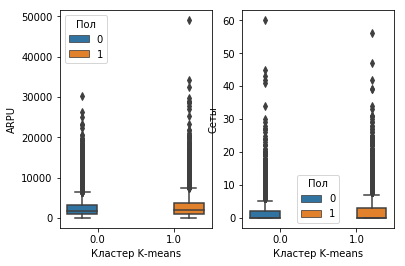

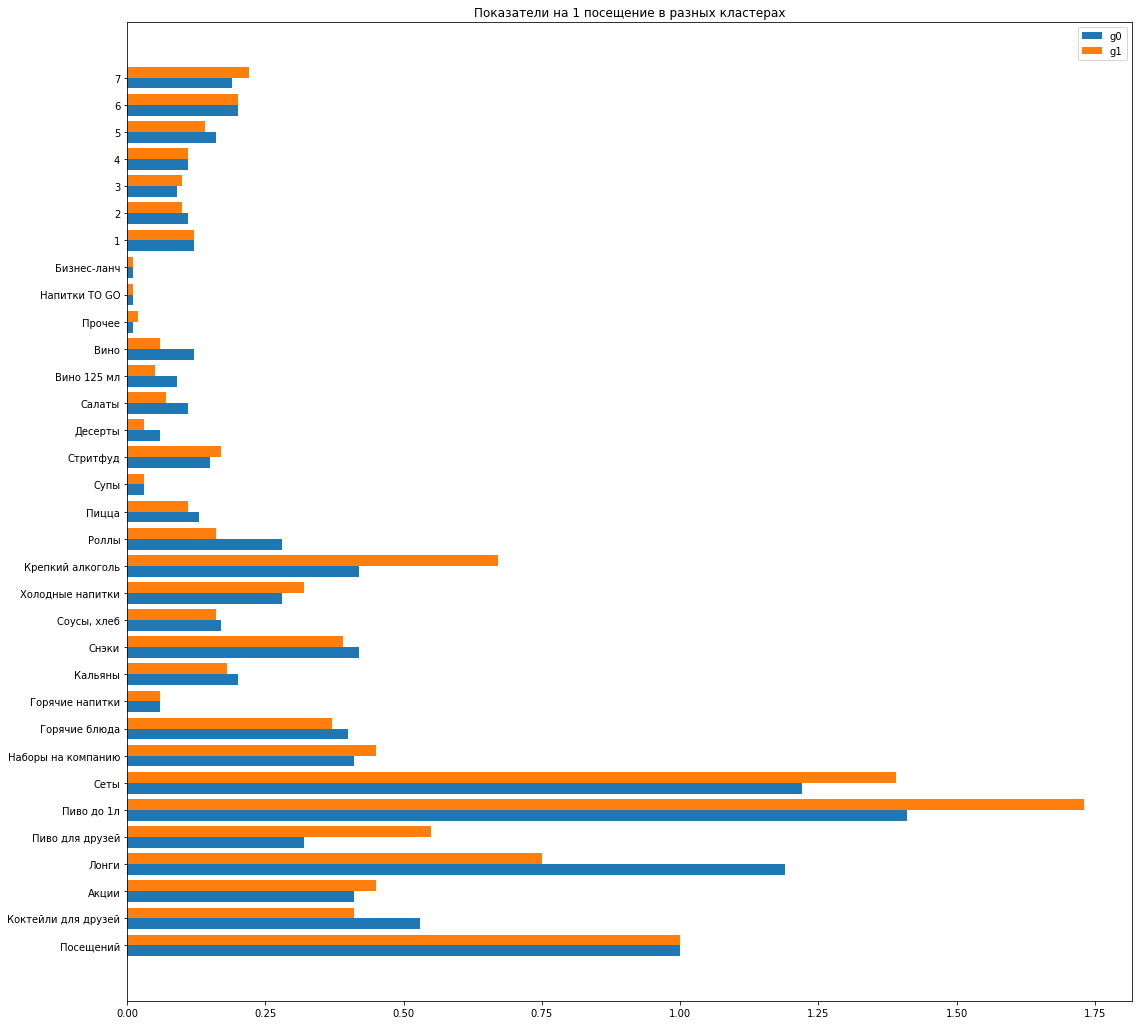



[0 1 2] [7561 5836 2180] 

,index,0,1,2,Per 1 visit for cluster0,Per 1 visit for cluster1,Per 1 visit for cluster2
0,К-во,7561.00,5836.00,2180.00,5439.57,4387.97,1178.38
1,Пол,0.00,1.00,1.00,0.00,0.75,0.54
2,ARPU,2567.72,2496.82,3862.94,1847.28,1877.31,2088.08
3,Посещений,1.39,1.33,1.85,1.00,1.00,1.00
4,Коктейли для друзей,0.74,0.50,0.89,0.53,0.38,0.48
5,Акции,0.57,0.75,0.43,0.41,0.56,0.23
6,Лонги,1.65,0.94,1.55,1.19,0.71,0.84
7,Пиво для друзей,0.45,0.69,1.12,0.32,0.52,0.61
8,Пиво до 1л,1.96,2.31,3.23,1.41,1.74,1.75
9,Сеты,1.69,1.76,2.84,1.22,1.32,1.54


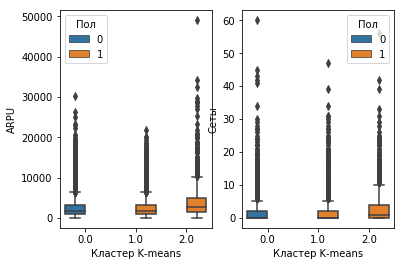

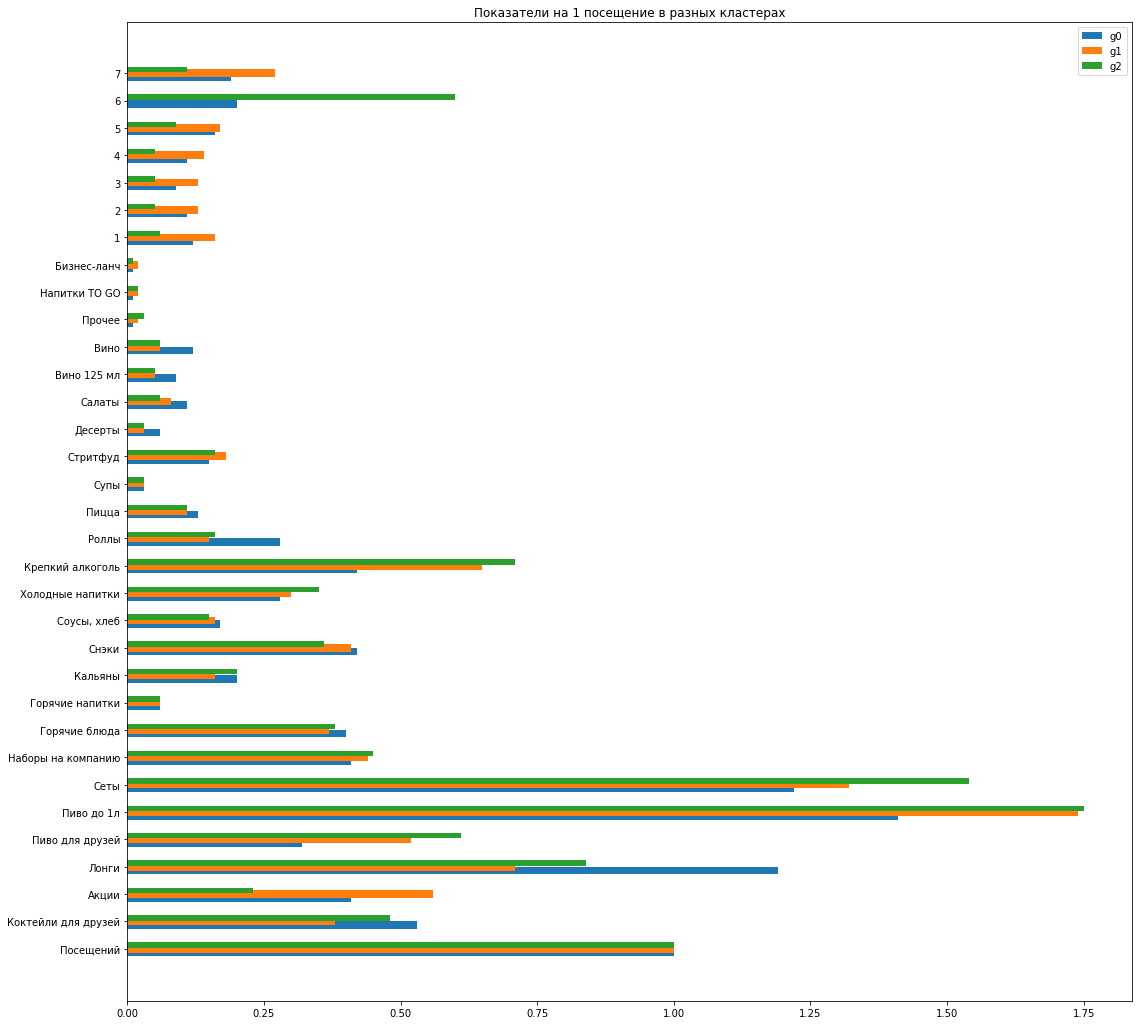



[0 1 2 3] [1546 5836 6015 2180] 

,index,0,1,2,3,Per 1 visit for cluster0,Per 1 visit for cluster1,Per 1 visit for cluster2,Per 1 visit for cluster3
0,К-во,1546.00,5836.00,6015.00,2180.00,878.41,4387.97,4662.79,1178.38
1,Пол,-0.00,1.00,0.00,1.00,-0.00,0.75,0.00,0.54
2,ARPU,3285.72,2496.82,2383.18,3862.94,1866.89,1877.31,1847.43,2088.08
3,Посещений,1.76,1.33,1.29,1.85,1.00,1.00,1.00,1.00
4,Коктейли для друзей,0.93,0.50,0.69,0.89,0.53,0.38,0.53,0.48
5,Акции,0.55,0.75,0.57,0.43,0.31,0.56,0.44,0.23
6,Лонги,1.95,0.94,1.58,1.55,1.11,0.71,1.22,0.84
7,Пиво для друзей,0.65,0.69,0.40,1.12,0.37,0.52,0.31,0.61
8,Пиво до 1л,2.67,2.31,1.77,3.23,1.52,1.74,1.37,1.75
9,Сеты,2.07,1.76,1.59,2.84,1.18,1.32,1.23,1.54


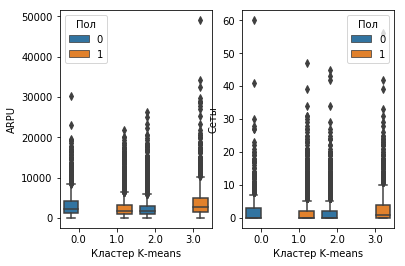

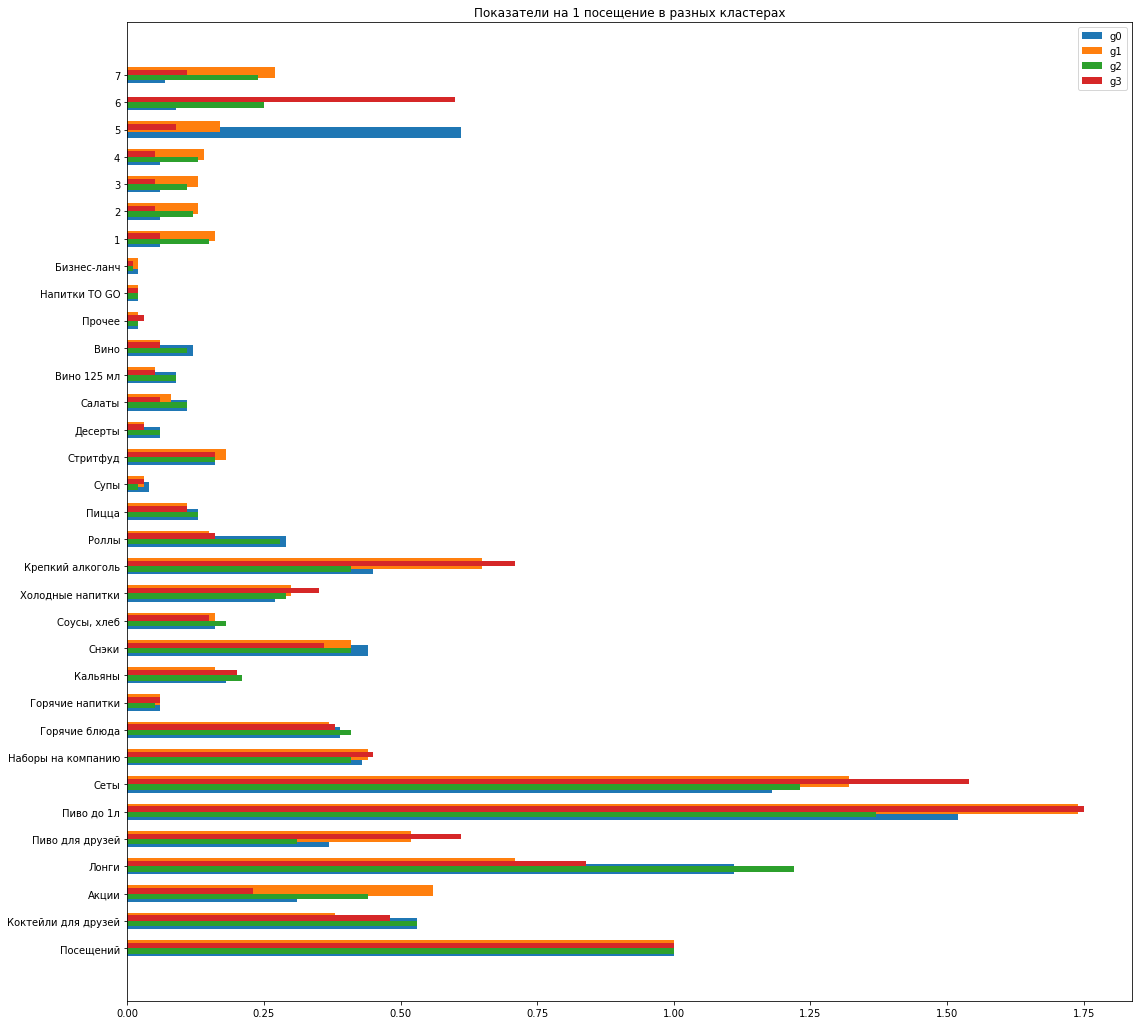

In [21]:
k_center(file_name1, 2)

## Итак, методом K-Means для нормализованных данных X2 рассмотрим 4 кластера, отличающихся по полу (м/ж) и дню недели для посещения (сб - для мужчин, пт - для девушек).

Средние цифры выглядят так:

* Для мужчин (кластеры номер 2 и 4):

Количество клиентов соответственно 5836 и 2180. За 1 месяц они в среднем тратят соответственно 2497 руб. за 1,33 посещений или же 3863 руб. за 1,85 посещений. Клиенты с более высокими расходами непропорционально больше заказывают "Коктейли для друзей" (3 порции в одном наборе), Кальянов; меньше подпадают под Акции и меньше заказывают Бизнес-Ланчей. Это сценарий посещения в прайм-тайм в календарную субботу (это может быть также ночное время пт/сб и сб/вс).

* Рассмотрим кластеры, которые сформированы девушками (номер 1 и 3):

Количество клиентов соответственно 1546 и 6015. 
За 1 месяц они в среднем тратят соответственно 3286 руб. за 1,76 посещений или же 2383 руб. за 1,29 посещений.
Клиенты с более высокими расходами непропорционально больше заказывают "Пиво для друзей" (3 порции в одном наборе), Крепкий алкоголь, Супы, Вино (в бутылках), Напитки TO GO (с собой), Бизнес-Ланч; меньше подпадают под Акции. Это сценарий посещения в прайм-тайм в календарную пятницу.

* Если дополнительно рассмотреть разбиение на только 2 кластера (также жёсткое по полу м/ж), то можно видеть, что  у девушек выше спрос на вино, лонги (коктейли), роллы, салаты и десерты по сравнению с мужчинами, и меньше интерес к крепкому алкоголю и "пиву для друзей". 

## В целом, данное разбиение нормализованных данных на 4 кластера видится обоснованным


In [ ]:
#break

# 4. Дополнительные методы


## 4.1. Результаты Агломеративной кластеризации

Максимальные коэф.силуэта без матрицы смежности / с матрицей смежности соответствуют разбиению на 2 кластера.

In [22]:
X = load(file_name1, 0)
X1 = load(file_name1, 1)
X2 = load(file_name1, 2)

In [23]:
list = [X,X1,X2]

In [24]:
def aglomerat(list):
    "Функция для агломеративной кластеризации"
    
    for number, j in enumerate(list):
        if number == 0:
            print('Для массива X')
        elif number == 1:
            print('Для массива X1')
        else:
            print('Для массива X2')
            
    
        for i in range(2,5):
            ac1 = AgglomerativeClustering(n_clusters=i,
                             affinity='euclidean', # “euclidean”, “l1”, “l2”, “manhattan”, 
                                                   # “cosine”, or “precomputed”
                             linkage='ward', # “ward”, “complete”, “average”, “single”
                            )
            with warnings.catch_warnings():
                warnings.filterwarnings(
                "ignore",
                    message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning)
                ac1.fit(j)
            y_pred1 = ac1.labels_.astype(np.int)
            s = silhouette_score(X=j, labels=y_pred1, metric='euclidean')
            print('число кластеров ', i, ":", round(s, 3))
            
    
        # строим матрицу смежности
        # делаем матрицу смежности симметричной

        connectivity = kneighbors_graph(X, n_neighbors=6, include_self=False)
        connectivity = 0.5 * (connectivity + connectivity.T)

        for i in range(2,5):
            ac1 = AgglomerativeClustering(n_clusters=i,
                             affinity='euclidean', # “euclidean”, “l1”, “l2”, “manhattan”, 
                                                   # “cosine”, or “precomputed”
                             linkage='ward', connectivity=connectivity 
                            )
            with warnings.catch_warnings():
                warnings.filterwarnings(
                "ignore",
                    message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning)
                ac1.fit(j)
            y_pred1 = ac1.labels_.astype(np.int)
            s = silhouette_score(X=j, labels=y_pred1, metric='euclidean')
            print('число кластеров с матрицей смежности ', i, ":", round(s, 3))
            
        print('\n')

In [25]:
aglomerat(list)

Для массива X
число кластеров  2 : 0.734
число кластеров  3 : 0.601
число кластеров  4 : 0.61
число кластеров с матрицей смежности  2 : 0.734
число кластеров с матрицей смежности  3 : 0.514
число кластеров с матрицей смежности  4 : 0.518


Для массива X1
число кластеров  2 : 0.24
число кластеров  3 : 0.238
число кластеров  4 : 0.233
число кластеров с матрицей смежности  2 : 0.214
число кластеров с матрицей смежности  3 : 0.171
число кластеров с матрицей смежности  4 : 0.171


Для массива X2
число кластеров  2 : 0.587
число кластеров  3 : 0.386
число кластеров  4 : 0.195
число кластеров с матрицей смежности  2 : 0.013
число кластеров с матрицей смежности  3 : -0.083
число кластеров с матрицей смежности  4 : -0.103




## 4.2. Иерархическая кластеризация 


* Для нестандартизированных данных X получили 2-4 кластера.

In [26]:
X=load(file_name1, 0)

In [27]:
def tree(X):
    "Построение дендрограммы"
    
    mergings = linkage(X.sort_values(by=['ARPU', 'Посещений', 'Пол']).values, method='complete')
    dendrogram(mergings, leaf_font_size=100, no_labels=True)
    
    return plt.show()

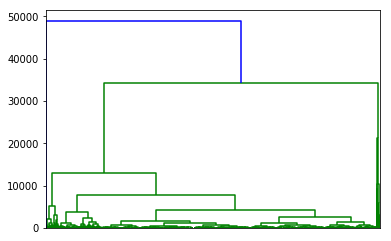

In [28]:
tree(X)

In [ ]:
#break

## 4.3. Проверка на данных, которые не содержат аномалий 


Алгоритм DBSCAN при максимальном коэф.силуэта определил в качестве выбросов 100 наблюдений из 15577.


Обратимся к размеченному файлу, очистим его от наблюдений с номером кластера "-1" и повторим кластеризацию.


### При разведочном анализе других существенных отличий от первоначальных данных не выявлено, кроме распределения ARPU и кол-ва посещений.

* Размах ARPU от 58 руб. до 21733 руб. (прежде было 49016 руб.) с медианным значением 1872 руб. (прежде 1889 руб). Максимальное кол-во посещений стало 10 (было 28).


### Кластеризация интерпретируется практически так же, как и на полных данных. 

* Коэффициенты силуэта несколько ниже. 

* Исключение составляет разбиение на 4 кластера нормализованных данных (по полу м/ж, ARPU, дню недели): более высокодоходные клиенты (и мужчины, и девушки) в среднем в 3 раза чаще бывают в баре в пятницу, чем менее доходные клиенты. Влияние субботы на данной выборке менее выявлено. 


In [29]:
Modif=load('70.xlsx', 0)
Modif.shape

(15577, 36)

In [30]:
Modif=Modif[Modif['Кластер DBSCAN']>=0]
X=Modif.drop('Кластер DBSCAN', axis='columns')
X.shape

(15477, 35)

In [31]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Пол,15477.0,0.514053,0.499819,0.0,0.0,1.0,1.0,1.0
ARPU,15477.0,2634.954175,2411.789151,58.0,1046.0,1872.0,3392.0,21733.0
Посещений,15477.0,1.390580,0.826823,1.0,1.0,1.0,2.0,10.0
Коктейли для друзей,15477.0,0.647671,1.491852,0.0,0.0,0.0,1.0,20.0
Акции,15477.0,0.591329,1.454624,0.0,0.0,0.0,0.0,26.0
Лонги,15477.0,1.340764,2.404748,0.0,0.0,0.0,2.0,28.0
Пиво для друзей,15477.0,0.612522,1.271171,0.0,0.0,0.0,1.0,21.0
Пиво до 1л,15477.0,2.179234,3.307483,0.0,0.0,1.0,3.0,44.0
Сеты,15477.0,1.829101,3.368999,0.0,0.0,0.0,2.0,47.0
Наборы на компанию,15477.0,0.604898,0.893493,0.0,0.0,0.0,1.0,9.0


Text(0.5, 0, 'ARPU, руб.')

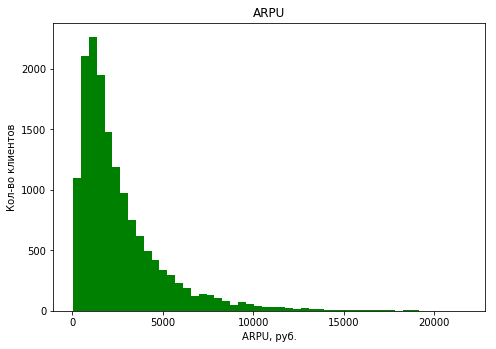

In [32]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(X['ARPU'], bins=50, color = 'green')
axes.set_title('ARPU')
axes.set_ylabel('Кол-во клиентов')
axes.set_xlabel('ARPU, руб.')

In [33]:
spisok = ['Пол', 'Посещений']
for i in spisok:
    print(X[i].value_counts())
    print('\n')

1    7956
0    7521
Name: Пол, dtype: int64


1     11489
2      2737
3       788
4       274
5        95
6        54
7        27
8         7
9         5
10        1
Name: Посещений, dtype: int64




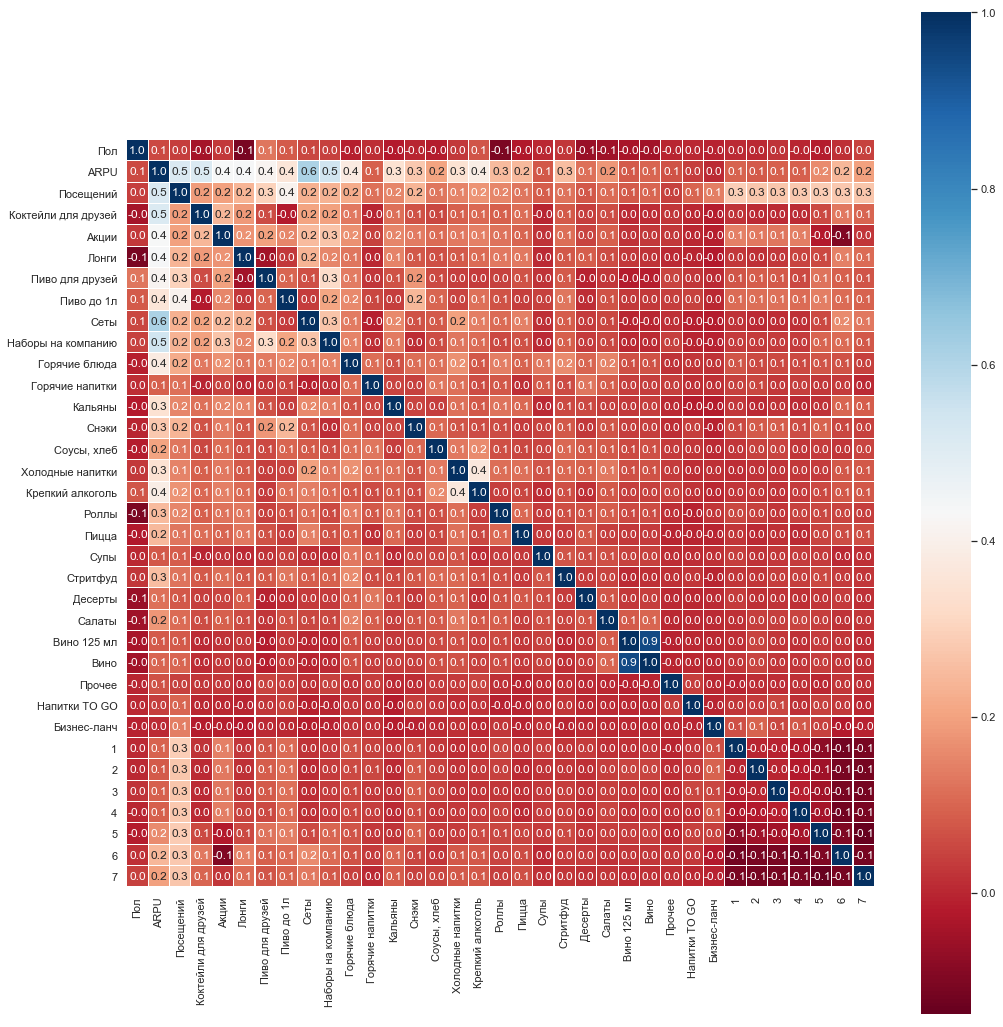

In [34]:
sns.set(font_scale=1)
plt.subplots(figsize=(15, 15))
sns.heatmap(X.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()
plt.savefig('car_corr_clear.png')

In [35]:
with pd.ExcelWriter('Clear.xlsx') as writer:  # doctest: +SKIP
    X.to_excel(writer, sheet_name='data', index=False)

In [36]:
file_name2 = 'Clear.xlsx'

In [37]:
X=load(file_name2, 0)
X.shape

(15477, 35)

In [38]:
X1=load(file_name2, 1)
X2=load(file_name2, 2)

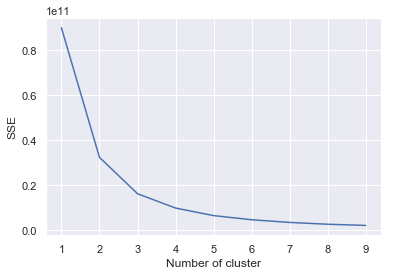

In [39]:
elbow(X)

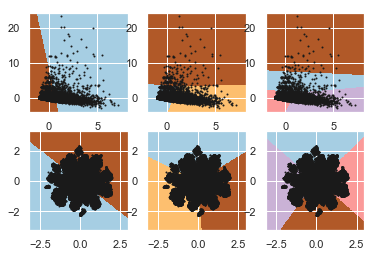

In [40]:
visual_comp(file_name2)

In [41]:
silhouette(file_name2, 0, 2, 9)

,К-во кластеров,Коэф.силуэта
0,2,0.696
1,3,0.628
2,4,0.593
3,5,0.576
4,6,0.554
5,7,0.553
6,8,0.543


[0 1] [12917  2560] 

,index,0,1,Per 1 visit for cluster0,Per 1 visit for cluster1
0,К-во,12917.00,2560.00,10501.63,1163.64
1,Пол,0.50,0.57,0.41,0.26
2,ARPU,1775.42,6965.82,1443.43,3166.28
3,Посещений,1.23,2.20,1.00,1.00
4,Коктейли для друзей,0.37,2.06,0.30,0.94
5,Акции,0.37,1.70,0.30,0.77
6,Лонги,0.95,3.30,0.77,1.50
7,Пиво для друзей,0.43,1.51,0.35,0.69
8,Пиво до 1л,1.77,4.26,1.44,1.94
9,Сеты,1.08,5.59,0.88,2.54


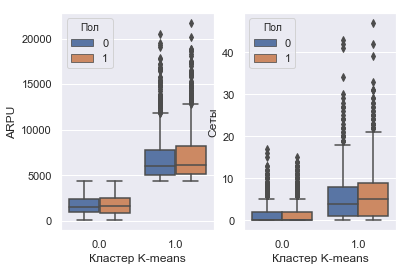

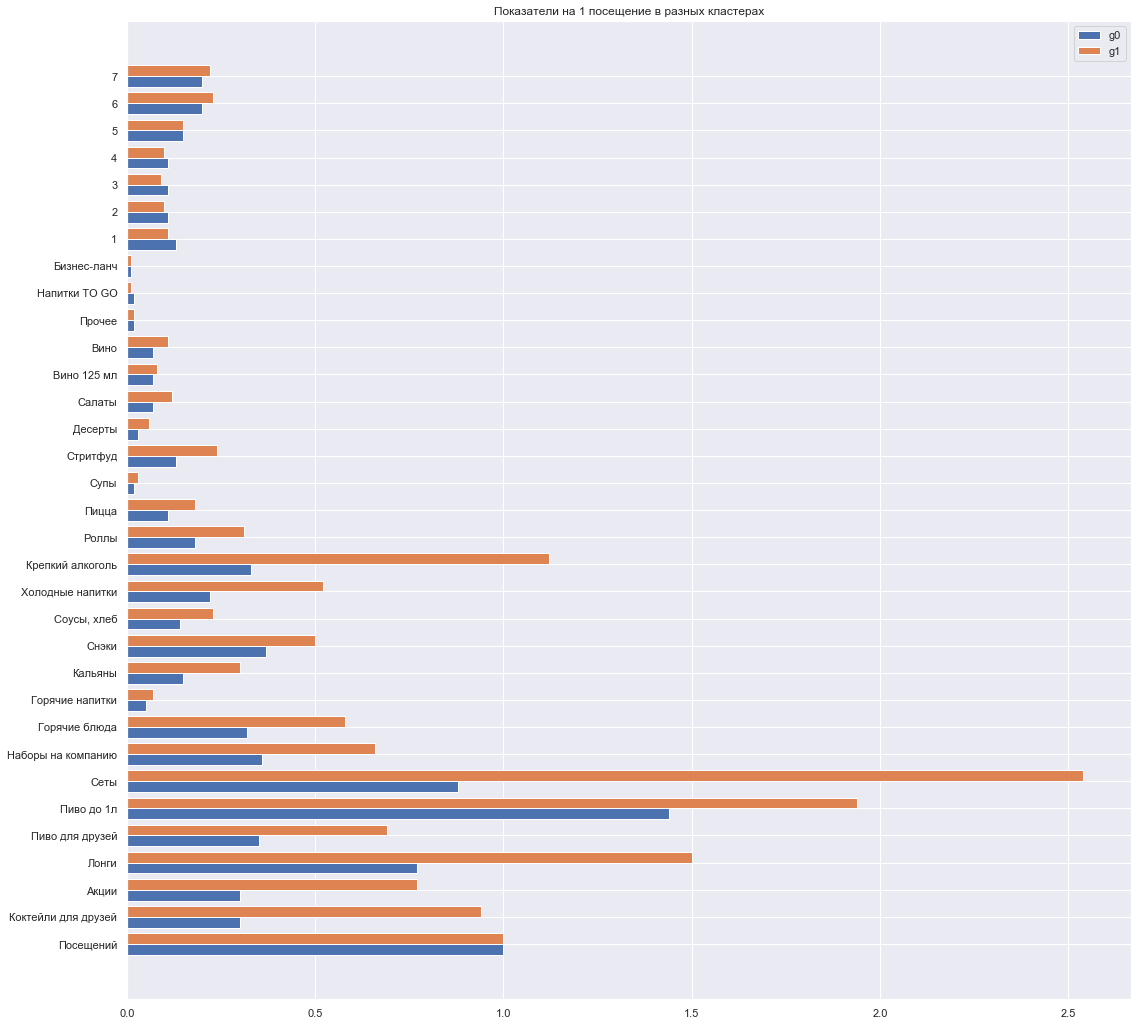



[0 1 2] [10329  4182   966] 

,index,0,1,2,Per 1 visit for cluster0,Per 1 visit for cluster1,Per 1 visit for cluster2
0,К-во,10329.00,4182.00,966.00,8981.74,2474.56,363.16
1,Пол,0.50,0.53,0.60,0.43,0.31,0.23
2,ARPU,1355.55,4188.82,9593.94,1178.74,2478.59,3606.74
3,Посещений,1.15,1.69,2.66,1.00,1.00,1.00
4,Коктейли для друзей,0.24,1.12,2.96,0.21,0.66,1.11
5,Акции,0.23,1.07,2.36,0.20,0.63,0.89
6,Лонги,0.76,2.10,4.27,0.66,1.24,1.61
7,Пиво для друзей,0.33,0.96,2.14,0.29,0.57,0.80
8,Пиво до 1л,1.54,2.96,5.58,1.34,1.75,2.10
9,Сеты,0.76,3.10,7.76,0.66,1.83,2.92


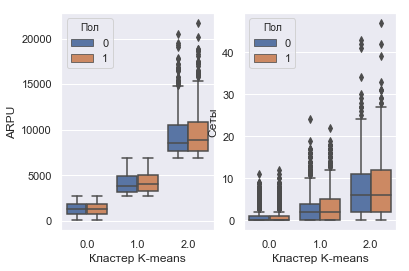

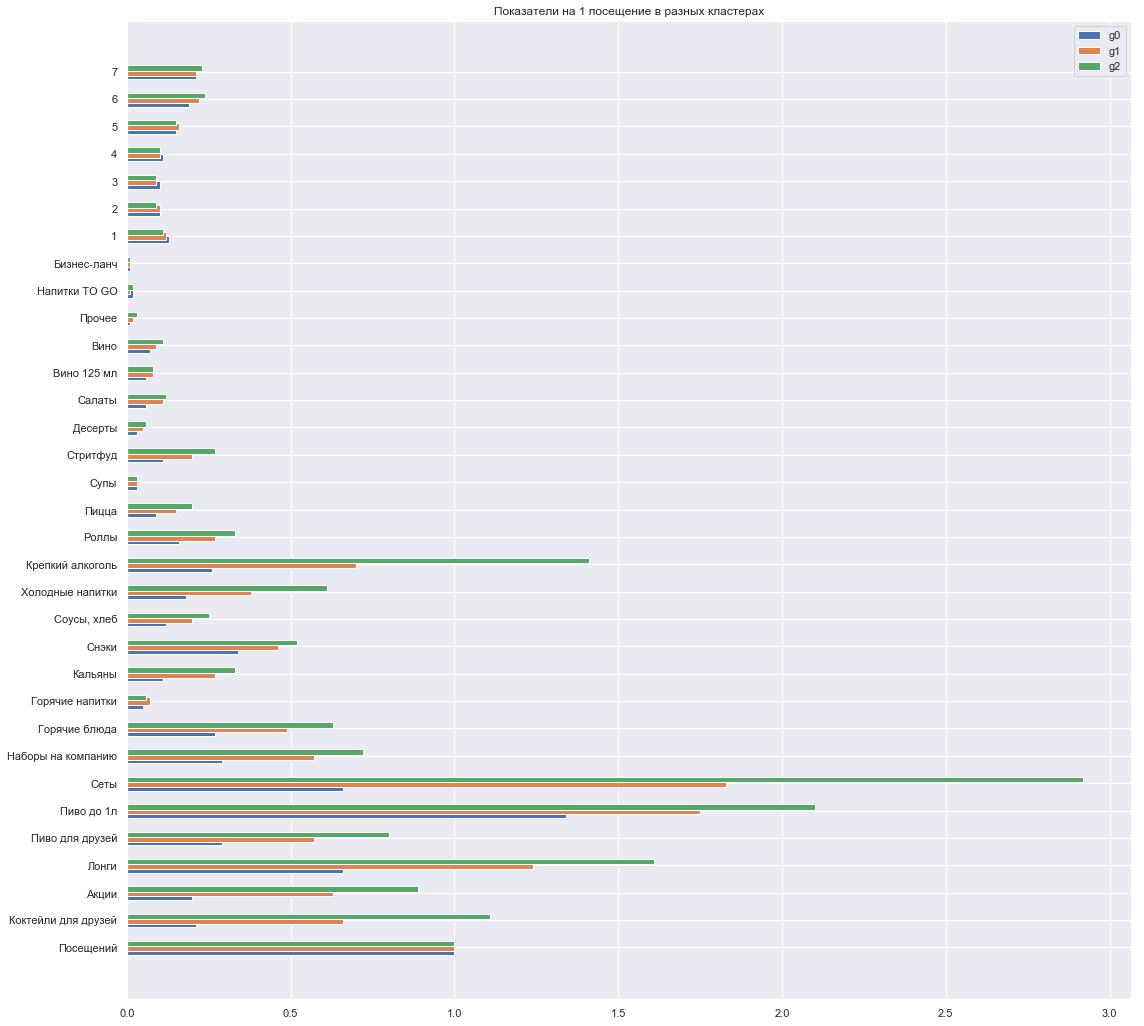



[0 1 2 3] [4566  467 8603 1841] 

,index,0,1,2,3,Per 1 visit for cluster0,Per 1 visit for cluster1,Per 1 visit for cluster2,Per 1 visit for cluster3
0,К-во,4566.00,467.00,8603.00,1841.00,3085.14,158.31,7750.45,893.69
1,Пол,0.52,0.62,0.49,0.56,0.35,0.21,0.44,0.27
2,ARPU,3122.41,11560.98,1140.82,6142.21,2109.74,3918.98,1027.77,2981.66
3,Посещений,1.48,2.95,1.11,2.06,1.00,1.00,1.00,1.00
4,Коктейли для друзей,0.75,3.42,0.19,1.82,0.51,1.16,0.17,0.88
5,Акции,0.78,2.83,0.18,1.49,0.53,0.96,0.16,0.72
6,Лонги,1.58,4.90,0.66,3.03,1.07,1.66,0.59,1.47
7,Пиво для друзей,0.77,2.68,0.27,1.30,0.52,0.91,0.24,0.63
8,Пиво до 1л,2.50,6.63,1.42,3.79,1.69,2.25,1.28,1.84
9,Сеты,2.12,9.71,0.60,4.87,1.43,3.29,0.54,2.36


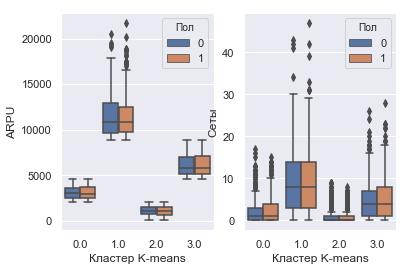

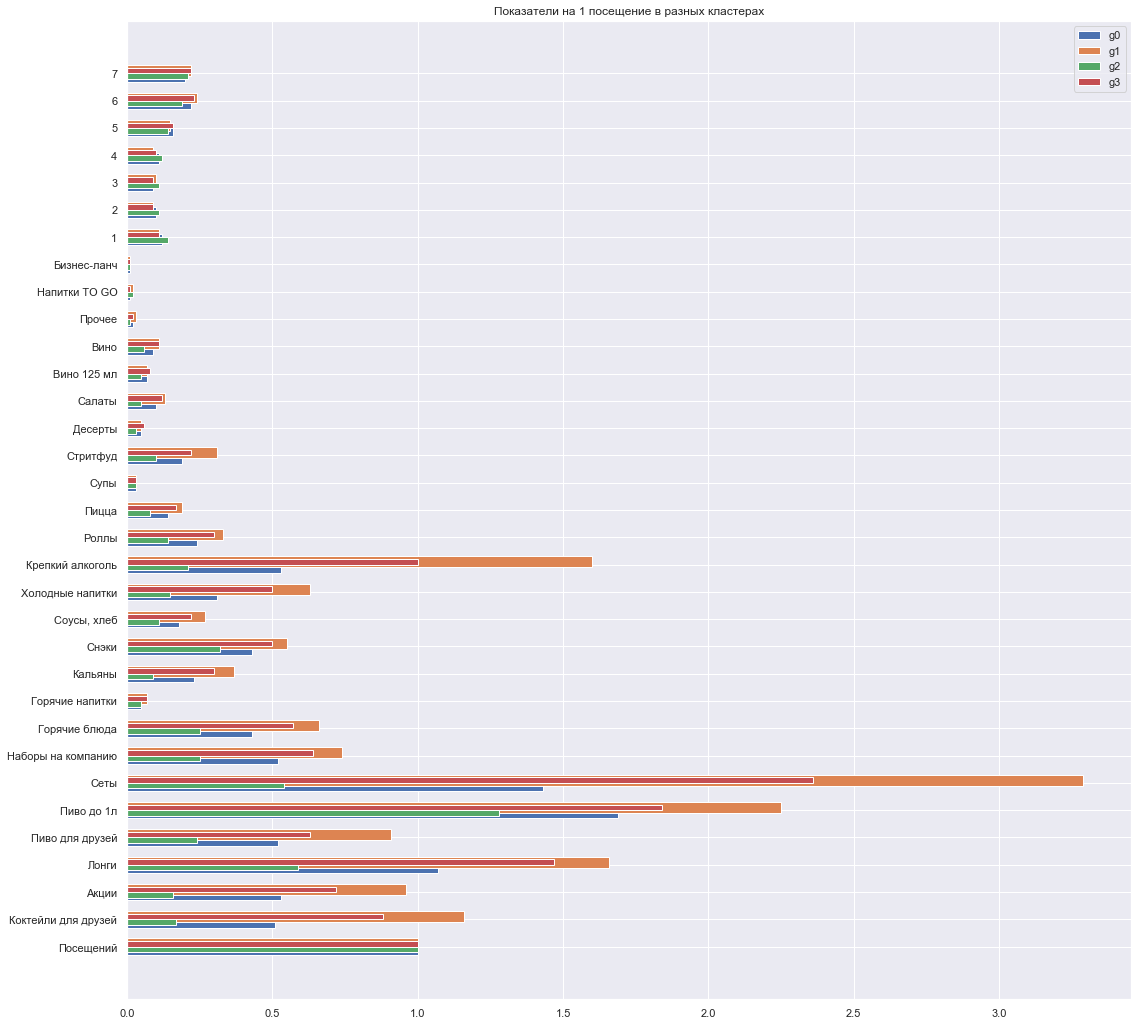

In [42]:
k_center(file_name2, 0)

In [43]:
silhouette(file_name2, 1, 2, 5)

,К-во кластеров,Коэф.силуэта
0,2,0.340
1,3,0.334
2,4,0.032


In [44]:
silhouette(file_name2, 2, 2, 5)

,К-во кластеров,Коэф.силуэта
0,2,0.477
1,3,0.393
2,4,0.311


[0 1] [7956 7521] 

,index,0,1,Per 1 visit for cluster0,Per 1 visit for cluster1
0,К-во,7956.00,7521.00,5602.82,5530.15
1,Пол,1.00,0.00,0.70,0.00
2,ARPU,2763.40,2499.08,1946.06,1837.56
3,Посещений,1.42,1.36,1.00,1.00
4,Коктейли для друзей,0.59,0.71,0.42,0.52
5,Акции,0.63,0.55,0.44,0.40
6,Лонги,1.08,1.61,0.76,1.18
7,Пиво для друзей,0.77,0.45,0.54,0.33
8,Пиво до 1л,2.44,1.90,1.72,1.40
9,Сеты,2.00,1.65,1.41,1.21


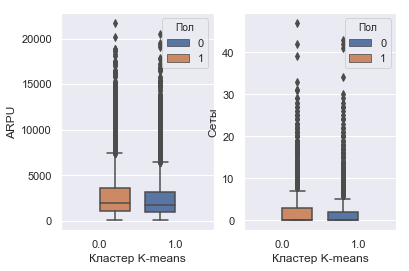

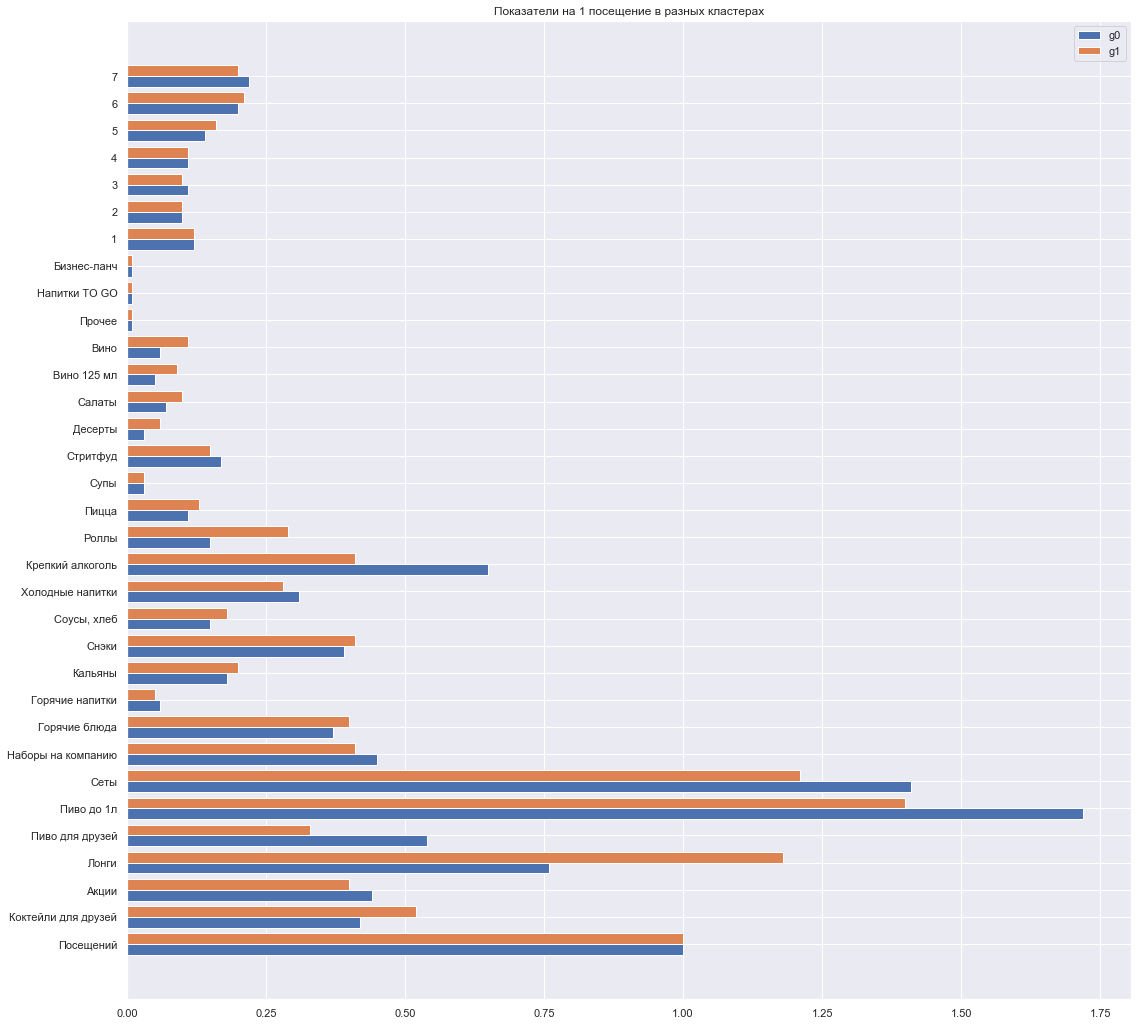



[0 1 2] [1342 7521 6614] 

,index,0,1,2,Per 1 visit for cluster0,Per 1 visit for cluster1,Per 1 visit for cluster2
0,К-во,1342.00,7521.00,6614.00,502.62,5530.15,5652.99
1,Пол,1.00,0.00,1.00,0.37,0.00,0.85
2,ARPU,6959.63,2499.08,1911.98,2606.60,1837.56,1634.17
3,Посещений,2.67,1.36,1.17,1.00,1.00,1.00
4,Коктейли для друзей,1.66,0.71,0.37,0.62,0.52,0.32
5,Акции,1.69,0.55,0.42,0.63,0.40,0.36
6,Лонги,2.72,1.61,0.75,1.02,1.18,0.64
7,Пиво для друзей,1.90,0.45,0.54,0.71,0.33,0.46
8,Пиво до 1л,5.34,1.90,1.85,2.00,1.40,1.58
9,Сеты,5.30,1.65,1.33,1.99,1.21,1.14


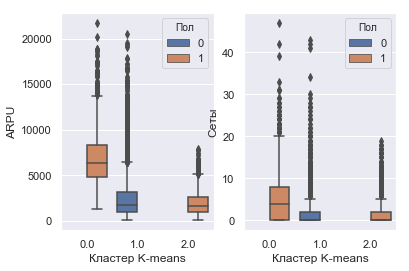

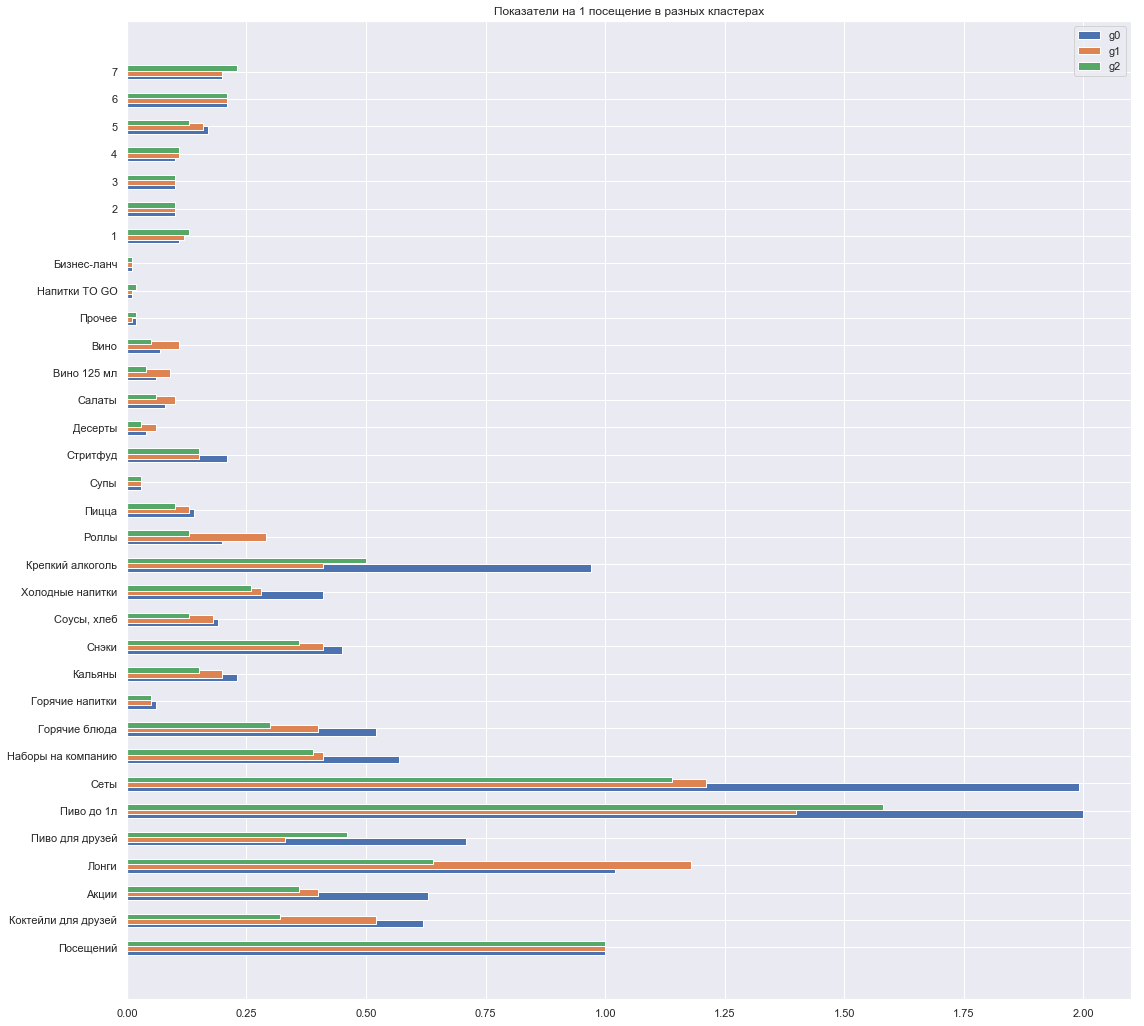



[0 1 2 3] [1329 1341 6192 6615] 

,index,0,1,2,3,Per 1 visit for cluster0,Per 1 visit for cluster1,Per 1 visit for cluster2,Per 1 visit for cluster3
0,К-во,1329.00,1341.00,6192.00,6615.00,553.75,502.25,5479.65,5653.85
1,Пол,-0.00,1.00,0.00,1.00,-0.00,0.37,0.00,0.85
2,ARPU,6069.12,6956.88,1732.83,1911.77,2528.80,2605.57,1533.48,1633.99
3,Посещений,2.40,2.67,1.13,1.17,1.00,1.00,1.00,1.00
4,Коктейли для друзей,1.94,1.66,0.45,0.37,0.81,0.62,0.40,0.32
5,Акции,1.43,1.69,0.36,0.42,0.60,0.63,0.32,0.36
6,Лонги,3.92,2.72,1.12,0.75,1.63,1.02,0.99,0.64
7,Пиво для друзей,1.01,1.90,0.33,0.54,0.42,0.71,0.29,0.46
8,Пиво до 1л,3.98,5.34,1.46,1.85,1.66,2.00,1.29,1.58
9,Сеты,4.24,5.30,1.09,1.33,1.77,1.99,0.96,1.14


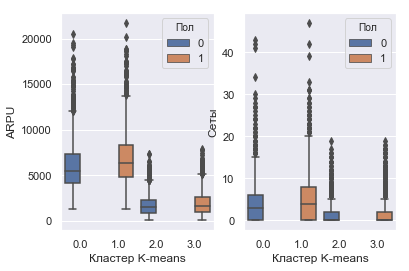

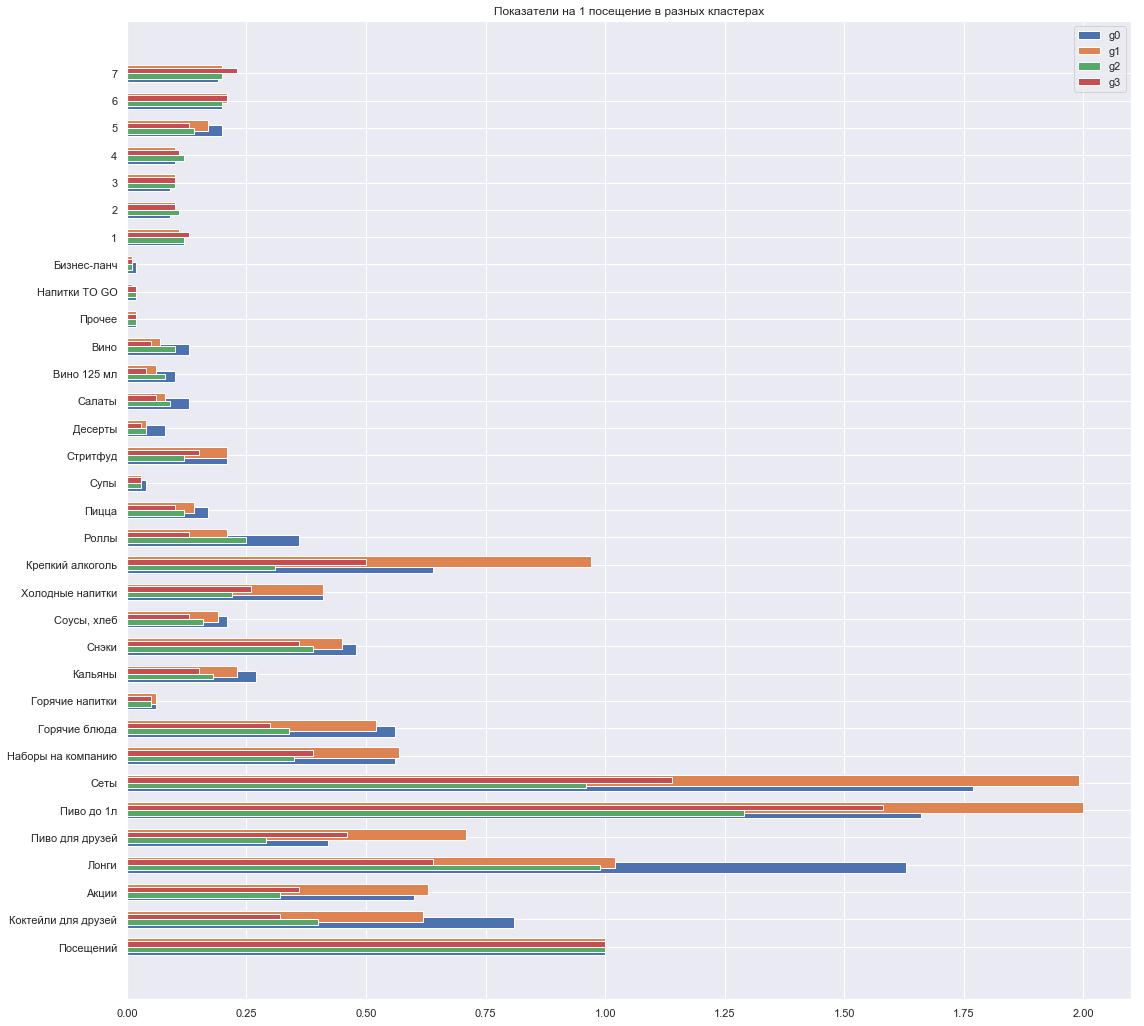

In [45]:
k_center(file_name2, 2)

In [46]:
X = load(file_name2, 0)
X1 = load(file_name2, 1)
X2 = load(file_name2, 2)

In [47]:
list = [X,X1,X2]

In [48]:
aglomerat(list)

Для массива X
число кластеров  2 : 0.733
число кластеров  3 : 0.614
число кластеров  4 : 0.54
число кластеров с матрицей смежности  2 : 0.608
число кластеров с матрицей смежности  3 : 0.627
число кластеров с матрицей смежности  4 : 0.625


Для массива X1
число кластеров  2 : 0.343
число кластеров  3 : 0.297
число кластеров  4 : 0.301
число кластеров с матрицей смежности  2 : 0.296
число кластеров с матрицей смежности  3 : 0.23
число кластеров с матрицей смежности  4 : -0.006


Для массива X2
число кластеров  2 : 0.477
число кластеров  3 : 0.293
число кластеров  4 : 0.154
число кластеров с матрицей смежности  2 : -0.0
число кластеров с матрицей смежности  3 : -0.146
число кластеров с матрицей смежности  4 : -0.141




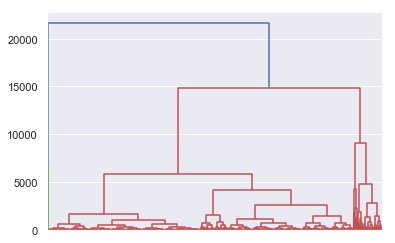

In [49]:
tree(X)

### Проверочные методы подтверждают разбиение на 2-4 основных кластера:

* разбивка на 2 кластера по ARPU (метод K-Means для нестандартизированных данных)


* разбивка на 3 кластера (3 разных сценарии посещения бара клиентами: редкое посещение (1,18 раз) с ARPU 1513 руб; более частое посещение (1,88 раз) с ARPU 5034 руб; частое посещение большой компанией - 3,65 раз с ARPU 12442 руб в месяц). Использовался метод K-Means для нестандартизированных данных.


* Вместо 2-х кластеров считаем целесообразным использовать разбивку на 4 кластера, которыая учитывает пол клиентов (м/ж) и день недели посещения (сб - для мужчин, пт - для девушек). Кластеры получены методом K-Means для нормализованных данных.